In [1]:
#Imports 
import sys
import os
import glob
from datetime import datetime

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, Sampler

In [2]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Current device is set to: ", device)

Current device is set to:  cuda


In [3]:
class HeartDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform

    def __len__(self):
        images = glob.glob('{}*jpg'.format(self.root_dir))
        return(len(images))

    def get_image(self, n):
        image = np.array(Image.open('{}{}.jpg'.format(self.root_dir, n)))
        return image

    def __getitem__(self, idx):
        source_index, target_index = idx
        source_image = np.array(Image.open('{}{}.jpg'.format(self.root_dir, source_index)))
        target_image = np.array(Image.open('{}{}.jpg'.format(self.root_dir, target_index)))
        if self.transform is not None:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

class HeartDatasetSampler(Sampler):
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        while True:
            num_images = len(self.dataset)
            
            # Randomly choose an image, and then choose a target frame within 20 frames
            # Original source must be all images - 20 otherwise the second random integer might 
            # pass the total number of images and index out of the array!
            source_index = np.random.randint(1, num_images - 20)
            target_index = source_index + np.random.randint(20)
            yield source_index, target_index

    def __len__(self):
        raise NotImplementedError

        
data_dir = 'C:/code/heart-tracking/data/processed/incision_1/'

transformer = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()])

dataset = HeartDataset(data_dir, transform=transformer)
sampler = HeartDatasetSampler(dataset)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=sampler, pin_memory=True, num_workers=0)

In [4]:
sys.path.append('../src/transporter/model/')
from transporter import *

IMAGE_CHANNELS = 3
K = 10

# Build Transporter Model architecture
feature_encoder = FeatureEncoder(IMAGE_CHANNELS)
pose_regressor = PoseRegressor(IMAGE_CHANNELS, K)
refine_net = RefineNet(IMAGE_CHANNELS)

transporter_model = Transporter(feature_encoder, pose_regressor, refine_net)
transporter_model.to(device=device)

Transporter(
  (feature_encoder): FeatureEncoder(
    (net): Sequential(
      (0): Block(
        (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Block(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Block(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): Block(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): Batch

In [6]:
model_dir = 'C:/code/heart-tracking/logs/transporter_Dec11_01-28-33/transporter_model.pth'

transporter_model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

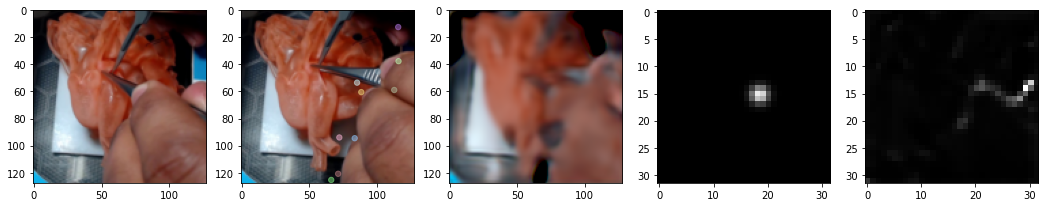

In [9]:
from matplotlib.patches import Circle

def get_random_color(pastel_factor=0.5):
    return [(x + pastel_factor) / (1.0 + pastel_factor)
            for x in [np.random.uniform(0, 1.0) for i in [1, 2, 3]]]


def color_distance(c1, c2):
    return sum([abs(x[0] - x[1]) for x in zip(c1, c2)])


def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color


def get_n_colors(n, pastel_factor=0.9):
    colors = []
    for i in range(n):
        colors.append(generate_new_color(colors, pastel_factor=0.9))
    return colors

with torch.no_grad():
    transporter_model.eval()
    
    for image, target in loader:
        break
        
    image = image.to(device=device)
    target = target.to(device=device)
    
    keypoints = transporter_model.point_net(image)
    reconstruction = transporter_model(image, target)
    
    fig, ax = plt.subplots(1, 5, figsize=(18, 5))
    idx = 6
    k_idx = 4
    std = 0.1

    feature_maps = spatial_softmax(keypoints)
    gmap = gaussian_map(feature_maps, std)[idx, k_idx]

    ax[0].imshow(np.transpose(image[idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    ax[1].imshow(np.transpose(target[idx].cpu().numpy(), (1, 2, 0)))
    ax[2].imshow(np.transpose(reconstruction[idx].cpu().numpy(), (1, 2, 0)))
    ax[3].imshow(gmap.cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[4].imshow(feature_maps[idx, k_idx].cpu().numpy(), cmap='gray')

    locs = compute_keypoint_location_mean(spatial_softmax(transporter_model.point_net(target)))[idx]

    colors = get_n_colors(len(locs))
    for i, l in enumerate((locs + 1) / 2 * 128):
        ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2, 
                               color=colors[i], alpha=0.5))